In [ ]:
#!/usr/bin/env python3
"""
make_plots.py
~~~~~~~~~~~~~
Generate per-dataset / (λ₁,λ₂) graphics from optimisation traces.

Output tree
-----------
plots/
└── <dataset>/
    └── <l1>_<l2>/
        ├── objective_vs_iter.png
        ├── objective_vs_time.png
        ├── iter_time_boxplot.png
        └── totals.txt
"""

from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use("Agg")            # draw to PNGs, no GUI needed
import matplotlib.pyplot as plt

# ─────────────────────────────── configuration ────────────────────────────── #
RESULTS_DIR = Path("results")
PLOTS_DIR   = Path("plots")

#DATASETS    = ["boston", "Advertising", "winequality-red"]
DATASETS    = ["winequality-red"]
#L1_L2_PAIRS = ["0.0_0.0", "0.0_0.1"]
L1_L2_PAIRS = ["0.0_0.0"]
#ALGOS       = ["ista", "fista", "lbfgs", "lbfgs_fista"]
ALGOS = ["lbfgs"]
# suppress the Matplotlib <3.11 boxplot-labels warning
warnings.filterwarnings(
    "ignore",
    category=matplotlib.MatplotlibDeprecationWarning,
    message="The 'labels' parameter of boxplot",
)

# create top-level folder
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# ─────────────────────────────── helper utils ─────────────────────────────── #
def load_one_csv(path: Path, algo: str) -> pd.DataFrame | None:
    """Read *path* and add the 'algo' column. Skip if unreadable/empty."""
    try:
        df = pd.read_csv(path)
    except Exception as err:
        print(f"⚠️  could not read {path.name}: {err}")
        return None
    if df.empty:
        print(f"⚠️  {path.name} has no rows – skipped")
        return None
    #df = df.sort_values("Iteration")   # ensure chronological order
    df["algo"] = algo
    # per-iteration wall-time (Δt); prepend 0.0 so arrays align
    df["iter_time"] = np.diff(df["time"], prepend=0.0)
    #if path.name == "lbfgs_boston_0.0_0.0.csv":
        #print(df)
        #print(df["objective"])
    return df


def save_objective_vs_iter(df: pd.DataFrame, out: Path, title: str):
    plt.figure()
    #remove first iteration
    # df = df[df["Iteration"] > 10]
    # array of number of rows in df
    x_axis = np.arange(df.shape[0])
    print(df.shape)
    for algo, grp in df.groupby("algo"):
        # print only points

        plt.plot(grp["Iteration"], grp["objective"], label=algo, linewidth = 1.5)
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("objective f(x)")
    plt.title(title + "  –  objective vs iteration")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out, dpi=300)
    plt.close()


def save_objective_vs_time(df: pd.DataFrame, out: Path, title: str):
    plt.figure()
    for algo, grp in df.groupby("algo"):
        plt.plot(grp["time"] * 1e3,               # seconds → ms
                 grp["objective"],
                 label=algo, linewidth=1.3)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("time (ms)")
    plt.ylabel("objective f(x)")
    plt.title(title + "  –  objective vs time")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out, dpi=300)
    plt.close()


def save_iter_time_box(df: pd.DataFrame, out: Path, title: str):
    plt.figure()
    box_data, labels, max_v, mean_v = [], [], [], []
    for algo, grp in df.groupby("algo"):
        it = grp["iter_time"].to_numpy()
        if it.size == 0:
            continue
        box_data.append(it)
        labels.append(algo)
        max_v.append(it.max())
        mean_v.append(it.mean())

    if not box_data:
        return                      # nothing to plot
    plt.boxplot(box_data, tick_labels=labels,
                patch_artist=True, showfliers=False)
    # red ♦ at max, annotate mean
    for i, (mx, av) in enumerate(zip(max_v, mean_v), start=1):
        plt.plot(i, mx, marker="D", color="red")
        plt.text(i, av, f"{av:.4f}s",
                 ha="center", va="bottom", fontsize=8)
    plt.ylabel("time per iteration (s)")
    plt.title(title + "  –  per-iteration time")
    plt.tight_layout()
    plt.savefig(out, dpi=300)
    plt.close()


def save_totals(df: pd.DataFrame, out: Path):
    totals = df.groupby("algo")["time"].max().sort_values()
    lines = [f"{a:15s} {t:.6f} s" for a, t in totals.items()]
    out.write_text("\n".join(lines))


# ────────────────────────────── main generation ───────────────────────────── #
for dataset in DATASETS:
    for lam in L1_L2_PAIRS:
        out_dir = PLOTS_DIR / dataset / lam
        out_dir.mkdir(parents=True, exist_ok=True)

        # gather CSVs for this dataset & λ-pair
        #group_frames = []
        #for algo in ALGOS:
        #    csv_path = RESULTS_DIR / f"{algo}_{dataset}_{lam}.csv"
        #    if not csv_path.exists():
        #        print(f"⚠️  missing file {csv_path.name}")
        #        continue
        #    if (df := load_one_csv(csv_path, algo)) is not None:
        #        group_frames.append(df)
#
        #if not group_frames:
        #    print(f"⚠️  no data for {dataset} / {lam} – skipped")
        #    continue
#
        ##data = pd.concat(group_frames, ignore_index=True)
        #title_stub = f"{dataset}   λ1,λ2={lam}"
#
        #save_objective_vs_iter(group_frames, out_dir / "objective_vs_iter.png", title_stub)
        #save_objective_vs_time(group_frames, out_dir / "objective_vs_time.png", title_stub)
        #save_iter_time_box(group_frames, out_dir / "iter_time_boxplot.png", title_stub)
        #save_totals(data, out_dir / "totals.txt")

        plt.figure()
        for algo in ALGOS:
            csv_path = RESULTS_DIR / f"{algo}_{dataset}_{lam}.csv"
            if not csv_path.exists():
                print(f"⚠️  missing file {csv_path.name}")
                continue

            df = pd.read_csv(csv_path)
            plt.plot(df["Iteration"], df["objective"], label=algo, linestyle='-', marker='o') 
            

        # what other than log is there?
        plt.yscale("log")
        plt.xlabel("Iteration")
        plt.ylabel("objective f(x)")
        plt.title(dataset + lam + "  –  objective vs iteration")
        plt.legend()
        plt.tight_layout()
        plt.savefig("plot", dpi=300)
        #plt.show()
        plt.close()

print("✓ all plots written to", PLOTS_DIR.resolve())


✓ all plots written to D:\documents\GitHub\CO\Implimentation\plots


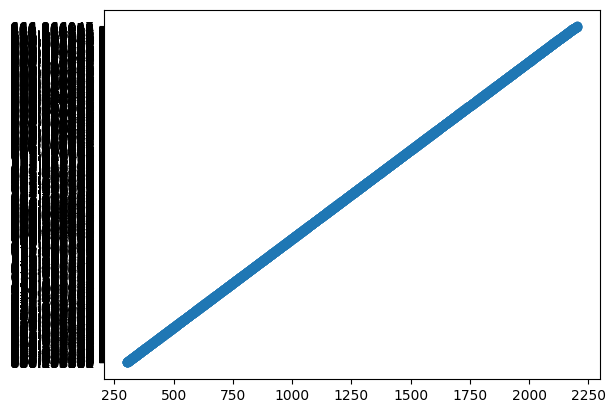

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
csv = pd.read_csv("results/lbfgs_winequality-red_0.0_0.0.csv", sep=",")

plt.figure()
plt.scatter(csv["Iteration"][300:], csv["objective"][300:], label="lbfgs", linestyle='-', marker='o')
#plt.yscale("log")
plt.show()





In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Read the CSV file
df = pd.read_csv('your_file.csv')  # Replace with your filename

# Step 2: Convert c1 and c2 to numeric (if needed)
df['c1'] = pd.to_numeric(df['Iteration'], errors='coerce')
df['c2'] = pd.to_numeric(df[''], errors='coerce')

# Step 3: Drop missing values
df = df.dropna(subset=['c1', 'c2'])

# Step 4: Plot the dependence
plt.figure(figsize=(8, 5))
plt.scatter(df['c1'], df['c2'], alpha=0.8)  # or use plt.plot(df['c1'], df['c2'], 'o')
plt.title('Dependence of c2 on c1')
plt.xlabel('c1')
plt.ylabel('c2')
plt.grid(True)
plt.tight_layout()
plt.show()
